## Imports and parameters

In [3]:
import os
from scipy.io import loadmat,savemat,mmread
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from matplotlib.colors import LinearSegmentedColormap,LogNorm
from voxnet.plotting import *
from voxnet.utilities import h5read
from skimage.measure import find_contours
import h5py

inj_site='VISp' # for virtual injections
inj_radius=1 # units of voxels
inj_stride=2
int_axis=1
plot_type = 'low_rank'
#save_stem='allvis_sdk_free_noshell'
save_stem='extra_vis_friday_harbor'
contour_list=[425,533,402]
lambda_str = '10'
output_dir='integrated_gaussian_%s_norm' % lambda_str
do_int_plots=True
base_dir=os.path.join('../connectivities',save_stem)
fn_matrices=os.path.join(base_dir, save_stem + '.mat')
fig_dir=os.path.join(base_dir, "figures")
int_plot_dir=os.path.join(fig_dir,output_dir)
try:
    os.makedirs(int_plot_dir)
except OSError: 
    pass
fout_virt=os.path.join(int_plot_dir,'virt_0.90_gaussian_lambda100.vtk')
fout_real=os.path.join(int_plot_dir,'real_0.90_gaussian_lambda100.vtk')
select_injections=[74, 76, 89, 234, 236, 238]
select_colors=["myred", "mygreen", "myblue", "myred", "mygreen","myblue"]
view_paths_fn = r'/home/kameron/work/allen/data/TopView/top_view_paths_10.h5'
bbox_100 = [132, 80, 114]

In [30]:
def map_to_surface(im, lut, paths, scale = 1, fun = np.max, set_nan = True):
    '''
    maps a gridded voxel image onto the cortical surface
    '''
    old_dims = im.shape
    # deal with scaling through re-indexing
    def remap_coord(c, old_dims, scale):
        new_dims = tuple(np.round(np.array(old_dims) * scale).astype(int))
        (I,J,K) = np.unravel_index(c, new_dims)
        I = np.floor(I / scale).astype(int)
        J = np.floor(J / scale).astype(int)
        K = np.floor(K / scale).astype(int)
        return np.ravel_multi_index((I,J,K), old_dims)
    # calculate output array
    output_pd = np.zeros(lut.shape, dtype=im.dtype)    
    # all pixels in surface view with a stream line
    ind = np.where(lut > -1)
    ind = zip(ind[0], ind[1])
    for curr_ind in ind:
        curr_path_id = lut[curr_ind]
        curr_path = paths[curr_path_id, :]
        curr_path_rescale = remap_coord(curr_path[np.nonzero(curr_path)], old_dims, scale)
        # image along path
        curr_pd_line = im.flat[curr_path_rescale]
        output_pd[curr_ind] = fun(curr_pd_line)
    if set_nan is True:
        output_pd[lut == -1] = np.nan
    return output_pd

## Load data

In [5]:
print "Making plots for " + save_stem
print output_dir

## Load data

mat=loadmat(fn_matrices)
locals().update(mat)

#X=h5read(os.path.join(base_dir, save_stem + '_X.h5'))
X=h5read(os.path.join(base_dir, save_stem + '_X_norm_by_Y.h5'))
#X=mmread(os.path.join(base_dir, save_stem + '_X.mtx'))

#Y_ipsi=h5read(os.path.join(base_dir, save_stem + '_Y_ipsi.h5'))
Y_ipsi=h5read(os.path.join(base_dir, save_stem + '_Y_norm_by_Y.h5'))
#Y_ipsi=mmread(os.path.join(base_dir, save_stem + '_Y_ipsi.mtx'))

#W_ipsi=h5read(os.path.join(base_dir, 'W_ipsi_%s.h5' % lambda_str)) # antero
#W_ipsi=h5read(os.path.join(base_dir, 'W_ipsi_%s.h5' % lambda_str)).T # retro
#W_ipsi=h5read(os.path.join(base_dir, 'W_low_rank_res_160.h5')) # residual
#W_ipsi=h5read(os.path.join(base_dir, 'W_low_rank_160.h5')) # low rank
W_ipsi=h5read(os.path.join(base_dir, 'W_norm_ipsi_10.h5')) # normalized

view_paths_file = h5py.File(view_paths_fn, 'r')
view_lut = view_paths_file['view lookup'][:]
view_paths = view_paths_file['paths'][:]
#view_paths_file.close()

print "W dims: %d x %d" % (W_ipsi.shape[0], W_ipsi.shape[1])
print "Data all loaded"

Making plots for extra_vis_friday_harbor
integrated_gaussian_10_norm
W dims: 7497 x 7497
Data all loaded


In [6]:
bounding_box(voxel_coords_source)

(array([ 71.,   3.,  69.]), array([ 103.,   34.,  104.]))

In [7]:
voxel_coords_target_ipsi

array([[ 79.,  14.,  95.],
       [ 79.,  14.,  96.],
       [ 79.,  14.,  97.],
       ..., 
       [ 83.,  16.,  88.],
       [ 83.,  16.,  89.],
       [ 83.,  17.,  88.]])

In [8]:
shape_regular_grid(voxel_coords_source)

array([ 33.,  32.,  36.])

In [39]:
col_label_list_source

array([[ 402.],
       [ 402.],
       [ 402.],
       ..., 
       [ 417.],
       [ 417.],
       [ 417.]])

In [49]:
test_col = map_to_regular_grid(W_ipsi[:,124], voxel_coords_target_ipsi, bbox_100)
test_col.shape

(132, 80, 114)

In [50]:
test_sfc = map_to_surface(test_col, view_lut, view_paths, scale=10)

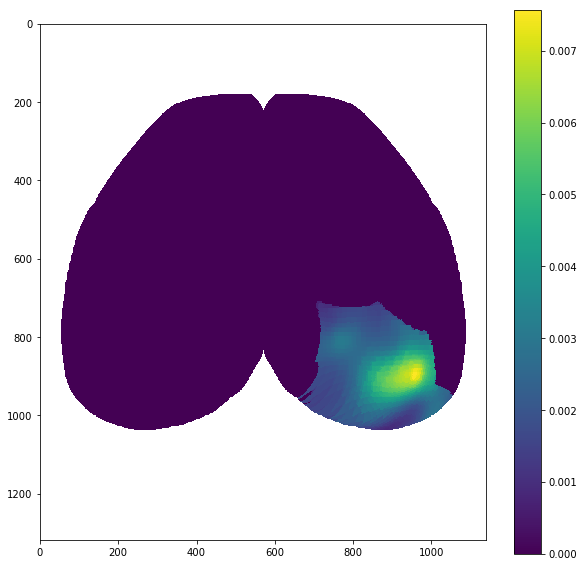

In [51]:
%matplotlib inline
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
h = ax.imshow(test_sfc)
fig.colorbar(h)

## Start plotting

In [ ]:
## Voxel lookup tables
inj_site_id = source_ids[np.where(source_acro==inj_site)]
coord_vox_map_source = index_lookup_map(voxel_coords_source)
coord_vox_map_target_contra = index_lookup_map(voxel_coords_target_ipsi)
coord_vox_map_target_ipsi = index_lookup_map(voxel_coords_target_contra)

## Compute region annotation
rearrange_2d = lambda(arr): arr
#rearrange_2d=lambda(arr): np.fliplr(arr)
#rearrange_2d=lambda(arr): np.swapaxes(arr,0,1)
# remap labels
new_labels = col_label_list_source.copy()
new_label_map = []
for i,label in enumerate(np.unique(new_labels)):
    new_labels[new_labels == label] = i+1
    new_label_map.append(label)
label_grid = map_to_regular_grid(new_labels,
                               voxel_coords_source).squeeze()
label_grid[label_grid==0] = np.nan
label_grid_2d = mode(label_grid, axis=int_axis)[0].squeeze()
label_grid_2d[label_grid_2d==0] = np.nan
label_unique = np.unique(new_labels)
label_grid_2d = rearrange_2d(label_grid_2d)

## Compute some region contours and setup helper functions
contours = find_contours(label_grid_2d, 385.5)
                                       # this threshold just happens
                                       # to work ok for visual areas

def plot_region_contours():
    '''
    Convenience function that plots some region boundaries

    '''
    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, c='gray')

def draw_region_labels():
    '''
    Convenience function that draws region labels
    '''
    for i,label in enumerate(np.unique(col_label_list_source)):
        x,y = centroid_of_region_2d(label_grid_2d, i+1)
        # region_name=source_acro[source_ids==label_lookup[newlab]][0][0]
        region_name=source_acro[source_ids==label][0][0]
        # print "%s centroid at (%d, %d)" % (region_name,x,y)
        plt.annotate(region_name, xy=(x-1., y))

## Plot region annotation
fig,ax=plt.subplots()
ax.imshow(label_grid_2d,
          cmap=plt.get_cmap('Accent'),
          interpolation='none')
plt.hold(True)
draw_region_labels()
plt.tick_params(axis='both', which='both', bottom='off',
                top='off', labelbottom='off', right='off',
                left='off', labelleft='off')
plt.xlabel('center - right', fontsize=24)
plt.ylabel('posterior - anterior', fontsize=24)
plt.savefig(os.path.join(int_plot_dir,"region_names.png"))
plt.close()

## Build virtual injections
Xvirt,inj_centers = build_injection_vectors(voxel_coords_source,
                                           coord_vox_map_source,
                                           col_label_list_source,
                                           inj_site_id,
                                           inj_radius,
                                           inj_stride)
num_virt=Xvirt.shape[1]
if num_virt < 1:
    raise Exception("No virtual injections fit!")

## Compute virtual projections
Yvirt_ipsi=np.dot(W_ipsi,Xvirt)

## Map to 3d grid
Xvirt_grid          = map_to_regular_grid(Xvirt, voxel_coords_source)
Yvirt_ipsi_grid     = map_to_regular_grid(Yvirt_ipsi, voxel_coords_target_ipsi)
Xreal_grid          = map_to_regular_grid(X, voxel_coords_source)
Yreal_ipsi_grid     = map_to_regular_grid(Y_ipsi, voxel_coords_target_ipsi)
Xvirt_int_grid      = np.sum(Xvirt_grid, axis=int_axis)
Yvirt_ipsi_int_grid = np.sum(Yvirt_ipsi_grid, axis=int_axis)

## Save VTKs --- volumetric data
print "Saving VTKs"
save_as_vtk_old(fout_virt,Xvirt_grid,Yvirt_ipsi_grid,
                voxel_coords_source,voxel_coords_target_ipsi)
save_as_vtk_old(fout_real,Xreal_grid,Yreal_ipsi_grid,
                voxel_coords_source,voxel_coords_target_ipsi)
print "VTKs saved."



## Plot virtual injections
def plot_integrated(fig,ax,inj,proj_cname,inj_cname,Xgrid,Ygrid):
    cax=ax.imshow(rearrange_2d(Ygrid[:,:,inj]),
                  cmap=plt.get_cmap(proj_cname),
                  clim=(0.0,0.03),
                  #clim=(-0.003,0.003),
                  #norm=LogNorm(vmin=1e-3),
                  interpolation='none')
    cbar = fig.colorbar(cax)
    tmp=rearrange_2d(Xgrid[:,:,inj])
    masked_tmp=np.ma.masked_where(tmp==0.0,tmp)
    ax.imshow(masked_tmp, cmap=plt.get_cmap(inj_cname),
              clim=(0.0,0.3), interpolation='none')
    return 

if do_int_plots:
    for inj in range(num_virt):
        y_inj=inj_centers[1,inj]
        fig,ax=plt.subplots()
        # Reds: linear colormap for connectivities
        plot_integrated(fig, ax, inj, 'Reds', 'Blues',
                        Xvirt_int_grid,Yvirt_ipsi_int_grid)
        # PuOr: diverging colormap for resids
        # plot_integrated(fig,ax,inj,'PuOr','Blues',
        #                 Xvirt_int_grid,Yvirt_ipsi_int_grid)
        plt.tick_params(axis='both', which='both', bottom='off',
                        top='off', labelbottom='off', right='off',
                        left='off', labelleft='off')
        plt.xlabel('center - right', fontsize=24)
        plt.ylabel('posterior - anterior', fontsize=24)
        plt.title('depth y = %d' % y_inj)
        plt.hold(True)
        plot_region_contours()
        draw_region_labels()
        # ax.imshow(edges,
        #    cmap=plt.get_cmap('gray_r'),interpolation='none',
        #    alpha=0.1)
        fig_file=os.path.join(int_plot_dir, "int_virt_inj%d.png" % inj)
        plt.savefig(fig_file)
        plt.close()
        print fig_file

## Setup select injection colors
cdictred={'red': [(0., 0., 0.),
                  (1., 1., 1.)],
          'green': [(0., 0., 0.),
                    (1., 0., 0.)],
          'blue': [(0., 0., 0.),
                   (1., 0., 0.)]}
cdictgreen={'red': [(0., 0., 0.),
                    (1., 0., 0.)],
            'green': [(0., 0., 0.),
                      (1., 1., 1.)],
            'blue': [(0., 0., 0.),
                     (1., 0., 0.)]}
cdictblue={'red': [(0., 0., 0.),
                   (1., 0., 0.)],
           'green': [(0., 0., 0.),
                     (1., 0., 0.)],
           'blue':  [(0., 0., 0.),
                     (1., 1., 1.)]}
red=LinearSegmentedColormap('myred',cdictred)
plt.register_cmap(cmap=red)
green=LinearSegmentedColormap('mygreen',cdictgreen)
plt.register_cmap(cmap=green)
blue=LinearSegmentedColormap('myblue',cdictblue)
plt.register_cmap(cmap=blue)

## Plot select injections
for i, inj in enumerate(select_injections):
    fig,ax=plt.subplots()
    color=select_colors[i]
    plot_integrated(fig, ax, inj, color, color,
                    Xvirt_int_grid, Yvirt_ipsi_int_grid)
    plt.tick_params(axis='both', which='both', bottom='off',
                    top='off', labelbottom='off', right='off',
                    left='off', labelleft='off')
    plt.xlabel('center - right', fontsize=24)
    plt.ylabel('posterior - anterior', fontsize=24)
    fig_file=os.path.join(int_plot_dir, "select_virt_inj%d.png" % i)
    plt.savefig(fig_file)
    plt.close()
